In [3]:
from MAUtil import *
from MAInit import *
from MACalc import *
from MAPost import *
import re
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["font.size"] = 14

In [4]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)

db = client.adsE_database
collection = db.adsE_collection

In [5]:
dictlis =  [#{'element':'Cu', 'face':'100'},
#            {'element':'Cu', 'face':'111'},
#            {'element':'Ag', 'face':'100'},
#            {'element':'Ag', 'face':'111'},
#            {'element':'Pt', 'face':'100'},
#            {'element':'Pt', 'face':'111'},
#            {'element':'Pd', 'face':'100'},           
           {'element':'Pd', 'face':'111'},] 
#            {'element':'Au', 'face':'100'},           
#            {'element':'Au', 'face':'111'},           
#            {'element':'Al', 'face':'100'},           
#            {'element':'Al', 'face':'111'},           
#            {'element':'Ni', 'face':'100'},           
#            {'element':'Ni', 'face':'111'},           
#            {'element':'Rh', 'face':'100'},           
#            {'element':'Rh', 'face':'111'},           
#            {'element':'Ru', 'face':'000'},           
#            {'element':'Zn', 'face':'000'},
#            {'element':'NiGa', 'face':'110'},
#            {'element':'CoPt3', 'face':'100'}]

In [6]:
dfall = []
df = []
dfpred = []

for i in range(len(dictlis)):
    inst = dataset_utilizer(**dictlis[i])
    dfall.append(inst.dfall)
    df.append(inst.df)
    dfpred.append(inst.dfpred)

In [7]:
### Exclude coverage > 1.0 ###
for i in range(len(df)):
    df[i] = df[i][df[i]['coverage'] <= 1.0]
    
### Exclude ads ene > 2.0 ###
for i in range(len(df)):
    df[i] = df[i][df[i]['aveadsE/suratom'] >= -2.0]

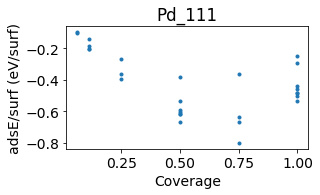

In [9]:
fig = plt.figure(figsize=(20,15))

for i in range(len(df)):
    ax = fig.add_subplot(5, 4, i+1)
    ax.plot(df[i]['coverage'], df[i]['aveadsE/suratom'], '.')
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['face']))
    ax.set_xlabel('Coverage')
    ax.set_ylabel('adsE/surf (eV/surf)')
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.6, wspace=0.35)
# plt.savefig('')
plt.show()

In [10]:
covset = []
for i in range(len(df)):
    covset.append(sorted(list(set(df[i]['coverage']))))
covset

[[0.0625, 0.1111111111111111, 0.25, 0.5, 0.75, 1.0]]

In [12]:
eneset = copy.deepcopy(covset)
for i in range(len(covset)):
    for j in range(len(covset[i])):
        eneset[i][j] = df[i][df[i]['coverage'] == covset[i][j]]['aveadsE/suratom'].min()

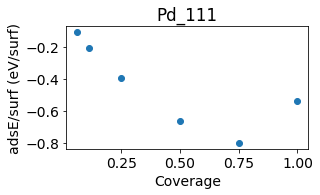

In [14]:
fig = plt.figure(figsize=(20,15))
 
for i in range(len(df)):
    ax = fig.add_subplot(5, 4, i+1)
    ax.plot(covset[i], eneset[i], 'o')
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['face']))
    ax.set_xlabel('Coverage')
    ax.set_ylabel('adsE/surf (eV/surf)')
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.6, wspace=0.35)
# plt.savefig('')
plt.show()

In [15]:
kb = 8.62E-05 # eV/K
T = 298 # K
Pref = 1 # bar

In [16]:
prange = [0.01, 0.1, 1, 10, 100, 1000]
pres = []

for i in range(len(eneset)):
    tmp = []
    for p in prange:
        tmp.append(eneset[i]-kb*T*np.log(p/Pref)*np.array(covset[i]))
    pres.append(tmp)

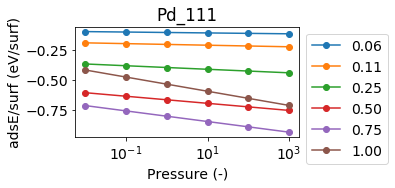

In [17]:
# for i in range(len(pres)):
#     plt.plot(prange, pres[i], 'o-')
#     plt.xscale('log')
#     plt.title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['mirror']))
#     plt.xlabel('Pressure (-)')
#     plt.ylabel('adsorption Energy per surface atom (eV)')
#     plt.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 0.8))
# #     plt.savefig('{}_{}_pourbaix.png'.format(dictlis[i]['element'], dictlis[i]['mirror']), bbox_inches='tight')
#     plt.show()
    
fig = plt.figure(figsize=(20,15))

for i in range(len(df)):
    ax = fig.add_subplot(5, 4, i+1)
    ax.plot(prange, pres[i], 'o-')
    plt.xscale('log')
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['face']))
    ax.set_xlabel('Pressure (-)')
    ax.set_ylabel('adsE/surf (eV/surf)')
    ax.legend(['{0:.2f}'.format(item) for item in covset[i]], bbox_to_anchor=(1, 1))
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.0, right=0.95, hspace=0.8, wspace=0.7)
# plt.savefig('')
plt.show()

In [55]:
from sklearn.linear_model import LinearRegression
Lin = LinearRegression()

In [56]:
def linearfit(X, y):
    index = 1
    Lin.fit(X[:index+1], y[:index+1])
    y_pred = Lin.predict(X)
    slope = Lin.coef_
    return y_pred, slope

In [57]:
densityset = []
for i in range(len(covset)):
    densityset.append(covset[i]/df[i][df[i]['unitlength'] ==1]['area'][0])

In [58]:
def func(X, slope, a2, a3, a4, a5, a6, a7, a8):
    return slope*X + a2*X**2 + a3*X**3 + a4*X**4 + a5*X**5 + a6*X**6 + a7*X**7 + a8*X**8

In [59]:
def MSE(A):
    a2, a3, a4, a5, a6, a7, a8 = A
    mse = 0
    for i in range(0,6):
        X, y = (list(x) for x in zip(*sorted(zip(densityset[i], eneset[i]))))
        X = np.array(X)
        y = np.array(y)    
        X_ = X.reshape(-1, 1)
        fitres, slope = linearfit(X_, y)

        mse += sum((y - func(X, slope, a2, a3, a4, a5, a6, a7, a8))**2)
    return mse

In [60]:
from scipy.optimize import minimize
sol = minimize(MSE, [1,1,1,1,1,1,1])
sol.x

array([  2.94617638, 207.33786796,  54.18047667,  11.69643123,
         2.9723561 ,   1.35008345,   1.0611724 ])

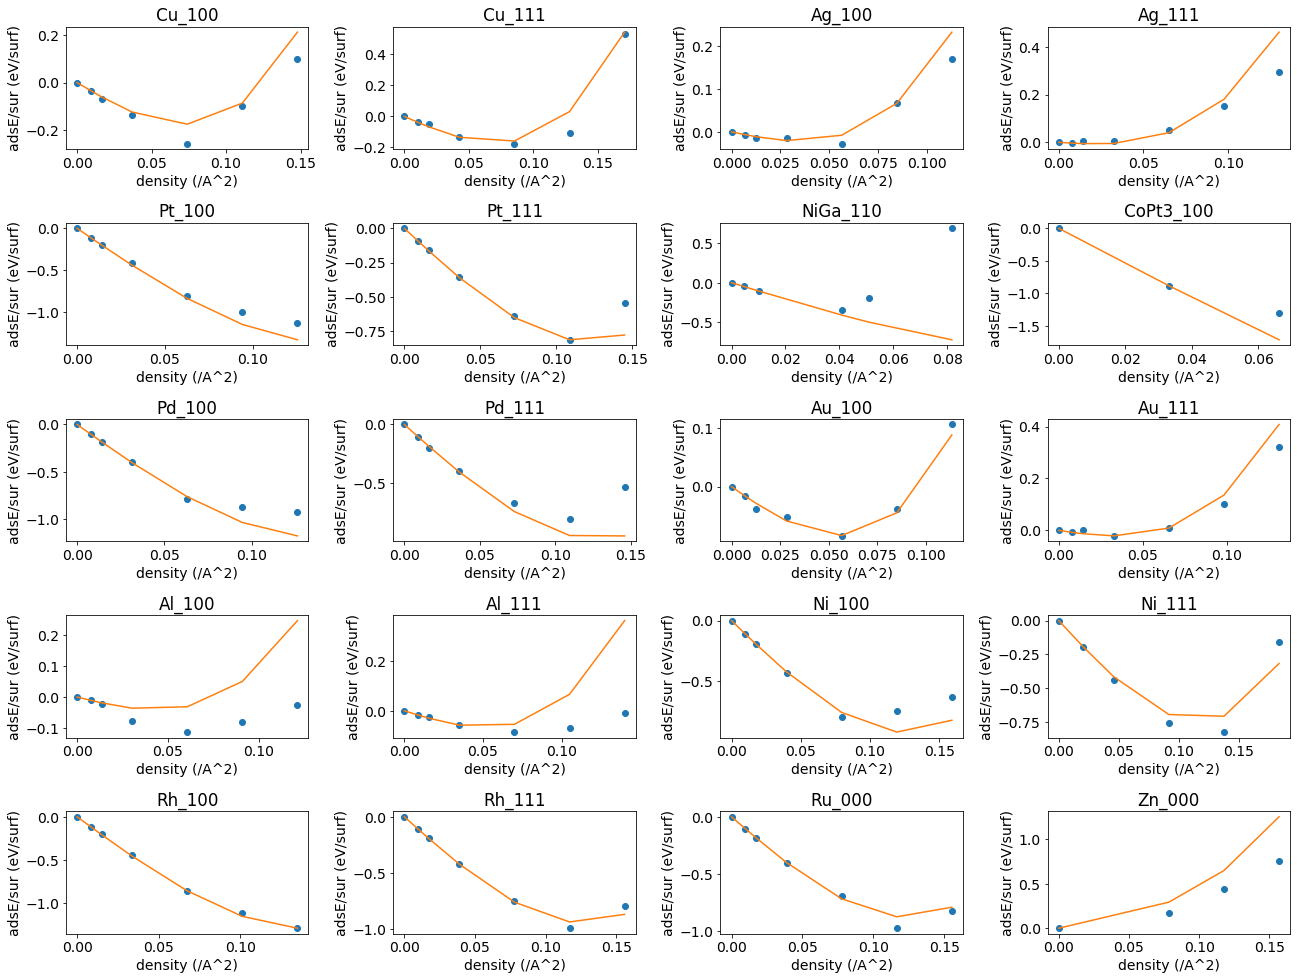

In [61]:
fig = plt.figure(figsize=(20,15))
 
for i in range(len(df)):
    ax = fig.add_subplot(5, 4, i+1)
    X, y = (list(x) for x in zip(*sorted(zip(densityset[i], eneset[i]))))
    X = np.array(X)
    y = np.array(y)    
    X = X.reshape(-1, 1)
    fitres, slope = linearfit(X, y)

    ax.plot(X, y, 'o')
    ax.plot(X, func(X, slope, *sol.x), '-')
    ax.set_title('{}_{}'.format(dictlis[i]['element'], dictlis[i]['mirror']))
    ax.set_xlabel('density (/A^2)')
    ax.set_ylabel('adsE/sur (eV/surf)')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.6, wspace=0.35)
# plt.savefig('')
plt.show()